# TITLE HERE

*Created by:* .... , January 2020 

*Blog post:* ADD LINK

*Summary:* This notebook provides a FILL IN TEXT HERE with [giotto-time](https://github.com/giotto-ai/giotto-time). 


## Library Imports

In [2]:
# giotto-time
# Feature creation
from giottotime.feature_creation import CalendarFeature
from giottotime.feature_creation import DetrendedFeature
from giottotime.feature_creation import PeriodicSeasonalFeature
from giottotime.feature_creation import ShiftFeature, MovingAverageFeature, ExogenousFeature
from giottotime.feature_creation import FeatureCreation
# Causality testing
from giottotime.causality_tests.shifted_pearson_correlation import ShiftedPearsonCorrelation
from giottotime.causality_tests.shifted_linear_coefficient import ShiftedLinearCoefficient
# Models
from giottotime.models.time_series_models import GAR
from giottotime.model_selection import FeatureSplitter
# Detrending
from giottotime.models import PolynomialTrend
from giottotime.models import ExponentialTrend

# Other libraries
# Data handling
import pandas as pd
import numpy as np
# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from src.scores import relative_mean_absolute_error, calculate_score
# Plotting
from src.plotting import plot_time_series
from src.tests import dickey_fuller_test
import matplotlib.pyplot as plt
# Statstools
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff

# Import Data

In [92]:
data = pd.read_csv('../Desktop/energy_demand_2016_2019.csv')
data['datetime'] = [pd.to_datetime(d) for d in data['datetime'].values]

In [93]:
time_series = data[['Load [MW]', 'datetime']].copy()
time_series.set_index('datetime', inplace=True) 
time_series = time_series.loc[~time_series.index.duplicated()] # Due to the summer/winter time change, some indices were duplicated. Remove them
time_series.head()

,Load [MW]
datetime,
2016-01-01 01:00:00,5589.913152
2016-01-01 02:00:00,5745.922407
2016-01-01 03:00:00,5868.390819
2016-01-01 04:00:00,5756.194908
2016-01-01 05:00:00,5557.777443


In [137]:
plot_time_series(time_series, 
                 y_columns=['Load [MW]'], 
                 names = ['Load [MW]'], 
                 title='Energy Demand Switzerland')

# Detrending

In [5]:
# Takes a long time (skip at first...)
polynomial_trend = PolynomialTrend(order=1)
polynomial_trend.fit(time_series['Load [MW]'])

data['Load [MW]'] = polynomial_trend.transform(time_series['Load [MW]'])

KeyboardInterrupt: 

# Causality Testing

The question we want to answer here is which time series causes another. In order to do this, we will fix the time series we want to make predictions. Then we shift another time series and calculate the correlation between the two to find the shift that gives us the highest correlation. Giotto-time then allows us to transform the dataframe by shifting each column by the best value. 

In [ ]:
cause = ShiftedLinearCoefficient(target_col="Temperature", )
cause.fit(data[['number of accidents', 'Temperature', 'windspeed']])
cause.max_corrs_

In [ ]:
cause.best_shifts_

What we find is that ... 

In [ ]:
cause.transform(data).head(10)

# Feature Creation

At this point we will create the features. It's worth to pause a second to learn how giotto-time handels the features X and the target values y.

**Create X and y**

In the figure below you can see the general setup. After applying the feature creation 'fit_transform' step, we get two dataframes X and y. In X we have the features as specified below. In y we have as many columns as we want to look into the future as specified by the 'horizon' variable in the feature creation step. This means that starting from a given date in the index we predict the value of the time series ... days into the future. This results in a triangle of NaN values for dates for which no data was given in the original time series.


**Split into X and y**

The 'train_test_splitter' function allows us to split X and y into a X_train and X_test and a y_train and y_test set respectively as indicated in the figure.

![title](data/figures/Xy_split.png)

In [150]:
# List of all features
# temperature_feature = ExogenousFeature(time_series['Load [MW]'], output_name='Load [MW]')
# windspeed_feature = ExogenousFeature(data['windspeed'], output_name='windspeed')
# weekly_period = PeriodicSeasonalFeature(start_date=time_series.index.min(), output_name='weekly')

from giottotime.feature_creation import CalendarFeature
from giottotime.feature_creation import MovingAverageFeature, PeriodicSeasonalFeature

year_period = PeriodicSeasonalFeature(output_name='yearly_season', period='365 days')
day_period = PeriodicSeasonalFeature(output_name='day_season', period='1 days')
mv_avg_2 = MovingAverageFeature(window_size=2, output_name='moving_average_2')
mv_avg_10 = MovingAverageFeature(window_size=2, output_name='moving_average_10')
shift_10 = ShiftFeature(shift=10, output_name='shift_10')

features_creation = FeatureCreation(
    horizon=24,
    time_series_features = [
        year_period,
        day_period,
        mv_avg_10,
        shift_10
    ]
)

X, y = features_creation.fit_transform(time_series)

Float64Index([                   0.0, 0.00011415525114155251,
              0.00022831050228310502, 0.00034246575342465754,
              0.00045662100456621003,  0.0005707762557077625,
               0.0006849315068493151,  0.0007990867579908676,
               0.0009132420091324201,  0.0010273972602739725,
              ...
                  3.9166666666666665,      3.916780821917808,
                    3.91689497716895,     3.9170091324200915,
                  3.9171232876712327,     3.9172374429223744,
                   3.917351598173516,     3.9174657534246577,
                   3.917579908675799,     3.9176940639269406],
             dtype='float64', name='datetime', length=34316)
Float64Index([                 0.0, 0.041666666666666664,  0.08333333333333333,
                             0.125,  0.16666666666666666,  0.20833333333333334,
                              0.25,   0.2916666666666667,   0.3333333333333333,
                             0.375,
              ...
      

# Prediction

In [151]:
train_test_splitter = FeatureSplitter()
X_train, y_train, X_test, y_test = train_test_splitter.transform(X, y)
y_test

,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,...,y_15,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24
datetime,,,,,,,,,,,,,,,,,,,,,
2019-11-30 01:00:00,5907.581028,6068.221615,6046.793026,5756.958990,5781.394676,5588.290635,5793.649515,5796.342608,5487.610410,5325.198871,...,5444.849572,5047.159665,5338.816217,5259.533254,5082.188801,5295.386971,5527.063301,5610.038978,5756.33588,NaN
2019-11-30 02:00:00,6068.221615,6046.793026,5756.958990,5781.394676,5588.290635,5793.649515,5796.342608,5487.610410,5325.198871,5640.817300,...,5047.159665,5338.816217,5259.533254,5082.188801,5295.386971,5527.063301,5610.038978,5756.335880,NaN,NaN
2019-11-30 03:00:00,6046.793026,5756.958990,5781.394676,5588.290635,5793.649515,5796.342608,5487.610410,5325.198871,5640.817300,5463.959571,...,5338.816217,5259.533254,5082.188801,5295.386971,5527.063301,5610.038978,5756.335880,NaN,NaN,NaN
2019-11-30 04:00:00,5756.958990,5781.394676,5588.290635,5793.649515,5796.342608,5487.610410,5325.198871,5640.817300,5463.959571,5474.775962,...,5259.533254,5082.188801,5295.386971,5527.063301,5610.038978,5756.335880,NaN,NaN,NaN,NaN
2019-11-30 05:00:00,5781.394676,5588.290635,5793.649515,5796.342608,5487.610410,5325.198871,5640.817300,5463.959571,5474.775962,5569.852068,...,5082.188801,5295.386971,5527.063301,5610.038978,5756.335880,NaN,NaN,NaN,NaN,NaN
2019-11-30 06:00:00,5588.290635,5793.649515,5796.342608,5487.610410,5325.198871,5640.817300,5463.959571,5474.775962,5569.852068,5444.849572,...,5295.386971,5527.063301,5610.038978,5756.335880,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30 07:00:00,5793.649515,5796.342608,5487.610410,5325.198871,5640.817300,5463.959571,5474.775962,5569.852068,5444.849572,5047.159665,...,5527.063301,5610.038978,5756.335880,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30 08:00:00,5796.342608,5487.610410,5325.198871,5640.817300,5463.959571,5474.775962,5569.852068,5444.849572,5047.159665,5338.816217,...,5610.038978,5756.335880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-11-30 09:00:00,5487.610410,5325.198871,5640.817300,5463.959571,5474.775962,5569.852068,5444.849572,5047.159665,5338.816217,5259.533254,...,5756.335880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
time_series_model = GAR(base_model=RandomForestRegressor())
time_series_model.fit(X_train, y_train)
predictions = time_series_model.predict(X_test)
predictions

,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,...,y_15,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24
datetime,,,,,,,,,,,,,,,,,,,,,
2019-11-30 01:00:00,5675.406870,5872.956631,5916.263958,6006.837587,6010.562721,5997.228007,6142.587250,6150.669829,6094.217229,6079.650334,...,6071.142782,6026.443872,6008.215790,6038.928262,5868.637532,5867.955496,5715.219618,5734.853345,5647.113792,5710.303935
2019-11-30 02:00:00,6056.011786,6180.579795,6094.908092,5932.659836,5922.618151,5930.794098,6037.311527,6194.591865,6190.056156,6139.822009,...,6060.686295,6086.701036,5980.202219,5956.329917,5754.462019,5904.741759,5890.600825,5946.532705,5950.371046,5967.056652
2019-11-30 03:00:00,6036.896283,5924.472459,5921.083097,5925.722710,6014.150419,6061.643992,6110.525003,6061.330554,5882.873364,5891.577896,...,5822.852728,5999.992535,5933.732830,5880.641319,5751.101688,5722.124675,5845.477352,5892.973348,5965.697735,6023.806907
2019-11-30 04:00:00,6114.462710,6078.508978,5929.146850,6014.152199,6071.544281,6082.098236,6053.417336,6064.315427,5973.351746,5793.616343,...,5898.443519,5977.099455,5915.901381,5873.668837,5776.263810,5715.697662,5623.594393,5804.614317,5997.555842,6052.733953
2019-11-30 05:00:00,5954.995545,5920.339206,5991.888459,6080.301189,6077.214602,6031.398484,6132.780333,5979.124139,5891.831018,5719.761598,...,5484.826571,5673.778830,5641.498907,5605.475494,5846.897229,5863.618987,5939.664287,5889.246608,5856.342323,5868.749694
2019-11-30 06:00:00,5825.663610,5870.214706,5920.151336,5825.272126,5857.159670,5926.985924,5915.373804,5969.690720,5988.106451,5831.130397,...,5378.735543,5417.779008,5379.549046,5524.468223,5736.698893,5860.210727,5853.492824,5764.577925,5724.979265,5723.437485
2019-11-30 07:00:00,5886.591943,5992.194694,5943.916538,5923.645048,5666.791681,5621.902876,5565.553552,5590.056964,5635.874615,5665.229275,...,5444.820354,5331.479845,5354.853640,5499.042088,5519.531230,5563.054570,5618.864733,5572.143954,5494.687488,5740.163549
2019-11-30 08:00:00,5740.217828,5887.534127,5963.251820,5840.786242,5658.881415,5644.356197,5589.212735,5698.156556,5656.787923,5706.145091,...,5297.459962,5220.000753,5328.383992,5357.779229,5403.097270,5515.969540,5605.266207,5532.803828,5495.826594,5645.653351
2019-11-30 09:00:00,5824.950743,5711.231612,5937.353846,5835.337628,5953.197587,5866.440171,5816.304742,5813.013251,5780.025603,5814.398943,...,5246.931290,5280.463399,5416.344842,5390.171371,5673.173794,5702.625554,5649.037510,5736.230109,5878.894965,5938.950647


In [153]:
# Plot predictions vs. reality
plot_data = pd.DataFrame([y_test['y_1'].dropna().values, predictions['y_1'].iloc[:-1].values]).T

plot_time_series(plot_data, 
                 y_columns=[0, 1], 
                 names = ['reference', 'predictions'], 
                 title='Accidents', 
                 y_axis_titles=['reference', 'predictions'])

Note that predictions were made for all time steps not only for the ones that we have data for in y_test. This score calculated below is 

In [135]:
score = calculate_score(y_test, predictions)
score

501.41238448829716

In [136]:
rel_score = calculate_score(y_test, predictions, relative_mean_absolute_error)
rel_score

0.09291627051405908

# Comparison (does not work yet, might not even be necessary)

Let's compare our result obtained with the GAR model to an ARMA model and let's see if giotto-time's model performed better.

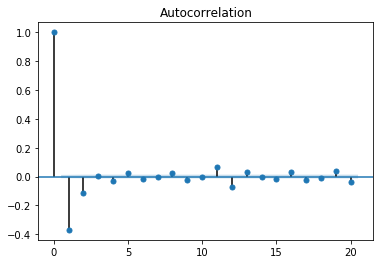

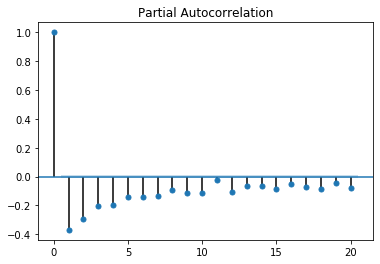

In [128]:
ratio = 0.9
idx = int(len(time_series)*ratio)
y_train_arma = time_series.iloc[:idx]
y_test_arma = time_series.iloc[idx:]

# Execute the tests to find the optimal ARMA model here
differenced = diff(y_train_arma, k_diff=2)
n_lags = 20
# ACF
plot_acf(differenced, lags=n_lags)
plt.show()

# PACF
plot_pacf(differenced, lags=n_lags)
plt.show()

In [129]:
arma_model = sm.tsa.ARMA(y_train_arma, (8, 6)).fit()

predictions = arma_model.predict(start=y_test_arma.index.min(), end=y_test_arma.index.max())

/Users/colinkalin/anaconda3/envs/time_test/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Users/colinkalin/anaconda3/envs/time_test/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/Users/colinkalin/anaconda3/envs/time_test/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

/Users/colinkalin/anaconda3/envs/time_test/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning:

overflow encountered in exp

/Users/colinkalin/anaconda3/envs/time_test/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning:

invalid value encountered in true_divide

/Users/colinkalin/anaconda3/envs/time_test/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarni

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
results = pd.DataFrame([predictions.values, y_test_arma.values.flatten()]).T
results.columns = ['pred', 'y_test']
results.index = predictions.index

In [ ]:
# Plot predictions vs. target values
plot_time_series(results, y_columns=['pred', 'y_test'], names=['predict', 'reference'])

In [ ]:
arma_model.maparams

In [ ]:
X_train.index.unique().shape, y_train.index.unique().shape, y_train.index.shape
for i in y_train.index:
    num = list(y_train.index).count(i)
    if num != 1:
        print(i, num)